In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 34 kB/s 
     |████████████████████████████████| 198 kB 52.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=65d32828a077e13e02658d24b46df4822cd4be63dfd488fcb68e819a545052c7
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
# import base do pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import math
from pyspark.sql.types import IntegerType


In [ ]:
sc = SparkContext()
sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
categoria = sqlContext.read.csv('/content/desafio_magalu/categoria.csv',sep ='|',inferSchema=True, header=True)
cidade = sqlContext.read.csv('/content/desafio_magalu/cidade.csv',sep ='|',inferSchema=True, header=True)
cliente = sqlContext.read.csv('/content/desafio_magalu/cliente.csv',sep ='|',inferSchema=True, header=True)
estado = sqlContext.read.csv('/content/desafio_magalu/estado.csv',sep ='|',inferSchema=True, header=True)
filial = sqlContext.read.csv('/content/desafio_magalu/filial.csv',sep ='|',inferSchema=True, header=True)
item_pedido = sqlContext.read.csv('/content/desafio_magalu/item_pedido.csv',sep ='|',inferSchema=True, header=True)
parceiro = sqlContext.read.csv('/content/desafio_magalu/parceiro.csv',sep ='|',inferSchema=True, header=True)
pedido = sqlContext.read.csv('/content/desafio_magalu/pedido.csv',sep ='|',inferSchema=True, header=True)
produto = sqlContext.read.csv('/content/desafio_magalu/produto.csv',sep ='|',inferSchema=True, header=True)
subcategoria = sqlContext.read.csv('/content/desafio_magalu/subcategoria.csv',sep ='|',inferSchema=True, header=True)
filial.show(1)

+---------+---------------+---------+
|id_filial|      ds_filial|id_cidade|
+---------+---------------+---------+
|        6|Filial - 000006|       22|
+---------+---------------+---------+
only showing top 1 row



# Modelagem Star Schema

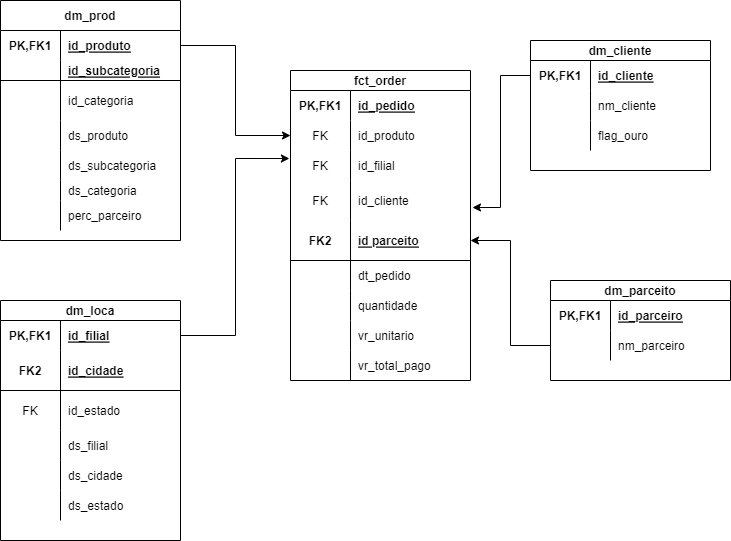


##Aqui cheguei à conclusão de utilizar o modelo estrela onde a tabela  fato é rodeada por tabelas dimensões. 
A tabela fato conecta-se às demais dimensões por múltiplas junções e as tabelas de dimensões conectam-se com apenas uma junção a tabela de fatos.
Desta forma a consulta é feita inicialmente nas tabelas de dimensão e depois nas tabelas de fatos, assegurando a precisão dos dados por meio de uma estrutura de chaves onde não é preciso percorrer todas as tabelas, garantindo um acesso mais eficiente de com melhor desempenho.



## Location Dimension

In [95]:
dm_loca = filial.join(cidade,filial.id_cidade == cidade.id_cidade, "inner") \
              .drop(cidade.id_cidade) \
              .join(estado,cidade.id_estado == estado.id_estado, "inner") \
              .drop(estado.id_estado)\
              .withColumn("ds_filial",regexp_extract(col('ds_filial'),"\d+",0))
dm_loca.show()

+---------+---------+---------+-----------+---------+---------+
|id_filial|ds_filial|id_cidade|  ds_cidade|id_estado|ds_estado|
+---------+---------+---------+-----------+---------+---------+
|      151|   000151|     7241| UBERLANDIA|        2|       AC|
|     1514|   001514|       59|AGUA BRANCA|        3|       AL|
|     1431|   001431|       59|AGUA BRANCA|        3|       AL|
|     1423|   001423|       59|AGUA BRANCA|        3|       AL|
|     1312|   001312|       59|AGUA BRANCA|        3|       AL|
|     1063|   001063|       59|AGUA BRANCA|        3|       AL|
|     1006|   001006|       59|AGUA BRANCA|        3|       AL|
|      946|   000946|       59|AGUA BRANCA|        3|       AL|
|      813|   000813|       59|AGUA BRANCA|        3|       AL|
|      682|   000682|       59|AGUA BRANCA|        3|       AL|
|      611|   000611|       59|AGUA BRANCA|        3|       AL|
|      603|   000603|       59|AGUA BRANCA|        3|       AL|
|      590|   000590|       59|AGUA BRAN

## Product Dimension

In [96]:
dm_prod = produto.join(subcategoria,produto.id_subcategoria.cast("long") == subcategoria.id_subcategoria.cast("long"), "inner") \
              .drop(subcategoria.id_subcategoria) \
              .join(categoria,subcategoria.id_categoria.cast("long") == categoria.id_categoria.cast("long"), "inner") \
              .drop(categoria.id_categoria)\
              .withColumn("id_subcategoria",col('id_subcategoria').cast("long"))\
              .withColumn("id_produto",col('id_produto').cast("long"))\
              .withColumn("ds_produto",regexp_extract(col('ds_produto'),"\d+",0))\
              .withColumn("ds_subcategoria",regexp_extract(col('ds_subcategoria'),"\d+",0))\
              .withColumn("ds_categoria",regexp_extract(col('ds_categoria'),"\d+",0))


In [97]:
dm_prod.show()

+----------+----------+---------------+---------------+------------+------------+-------------+
|id_produto|ds_produto|id_subcategoria|ds_subcategoria|id_categoria|ds_categoria|perc_parceiro|
+----------+----------+---------------+---------------+------------+------------+-------------+
|     12006|0000012006|            572|          00572|          18|         018|          1.0|
|     45183|0000045183|           2142|          02142|          16|         016|          3.0|
|     78905|0000078905|            140|          00140|          25|         025|          3.0|
|     79758|0000079758|           3132|          03132|           4|         004|          2.0|
|    117196|0000117196|             96|          00096|           4|         004|          2.0|
|    169903|0000169903|           1735|          01735|           4|         004|          2.0|
|    185406|0000185406|             82|          00082|           4|         004|          2.0|
|    201415|0000201415|           1519| 

## Parceiro Dimension

In [98]:
dm_parceiro = parceiro.withColumn("nm_parceiro",regexp_extract(col('nm_parceiro'),"\d+",0))\
    .withColumn("id_parceiro",parceiro.id_parceiro.cast("long"))
dm_parceiro.show()

+-----------+-----------+
|id_parceiro|nm_parceiro|
+-----------+-----------+
|          1|         01|
|          2|         02|
|          3|         03|
|          4|         04|
|          5|         05|
|          6|         06|
|          7|         07|
|          8|         08|
|          9|         09|
|         10|         10|
|         11|         11|
|         12|         12|
|         13|         13|
|         14|         14|
|         15|         15|
|         16|         16|
+-----------+-----------+



## Cliente Dimension

In [99]:
dm_cliente = cliente.withColumn("nm_cliente",regexp_extract(col('nm_cliente'),"\d+",0))\
    .withColumn("id_cliente",cliente.id_cliente.cast("long"))

dm_cliente.show()

+----------+----------+---------+
|id_cliente|nm_cliente|flag_ouro|
+----------+----------+---------+
|  78262350|0078262350|        0|
|  57301020|0057301020|        0|
|   4639167|0004639167|        1|
|  53130287|0053130287|        0|
|  16456085|0016456085|        0|
| 124100202|0124100202|        0|
|  15659567|0015659567|        0|
|  37375617|0037375617|        1|
|  52082515|0052082515|        0|
|  56214875|0056214875|        0|
| 137980527|0137980527|        0|
|  11806492|0011806492|        0|
| 112690290|0112690290|        1|
| 120559842|0120559842|        1|
| 140697495|0140697495|        0|
|  64431627|0064431627|        0|
| 113852445|0113852445|        1|
|  51864985|0051864985|        0|
| 113068442|0113068442|        0|
|  71256730|0071256730|        0|
+----------+----------+---------+
only showing top 20 rows



## Fact Order

In [138]:
fct_order = pedido.join(item_pedido,pedido.id_pedido.cast("long") == item_pedido.id_pedido.cast("long"), "inner")\
  .drop(item_pedido.id_pedido)\
  .withColumn("id_pedido",col('id_pedido').cast("long"))\
  .withColumn("id_parceiro",col('id_parceiro').cast("long"))\
  .withColumn("id_cliente",col('id_cliente').cast("long"))\
  .withColumn("dt_pedido",col('dt_pedido').substr(1,10))\
  .withColumn("ano",col('dt_pedido').substr(1,4))\
  .withColumn("mes",col('dt_pedido').substr(6,2))\
  .withColumn("dia",col('dt_pedido').substr(9,2))

In [136]:
fct_order.orderBy(fct_order.id_parceiro.desc()).show()

+-----------+----------+-----------+----------+---------+-------------+----------+----------+-----------+----+---+---+
|  id_pedido| dt_pedido|id_parceiro|id_cliente|id_filial|vr_total_pago|id_produto|quantidade|vr_unitario| ano|mes|dia|
+-----------+----------+-----------+----------+---------+-------------+----------+----------+-----------+----+---+---+
|46625106216|2021-06-02|         16| 122492800|      876|        97.49|   4885660|         1|      97.49|2021| 06| 02|
|46625724516|2021-06-02|         16|  59430282|     1691|        77.99|   3440795|         1|      77.99|2021| 06| 02|
|46625154516|2021-06-02|         16| 138937837|     1587|       129.99|   2610992|         1|     129.99|2021| 06| 02|
|46624857016|2021-06-02|         16|  82470070|      194|        90.99|   2038486|         1|      90.99|2021| 06| 02|
|46625178016|2021-06-02|         16|  17800322|       94|        38.99|    800898|         1|      38.99|2021| 06| 02|
|46624958516|2021-06-02|         16|  17800322| 

## Cálculo da comissão por produto
Aqui realizamos o cálculo da comissão por produto levando em consideração sua categoria e sua porcentagem.

In [139]:
agg_fact_order = fct_order.join(dm_prod,fct_order.id_produto == dm_prod.id_produto, "inner")\
  .withColumn("comission",(col("vr_unitario") * (col("perc_parceiro")/100)) * col("quantidade"))\
  .withColumn("vlr_total_pedido",(col("vr_unitario") * col("quantidade")))\
  .groupBy(col("id_parceiro"),col('dt_pedido').substr(1,7).alias("dt_anomes"))\
  .agg(sum("comission").cast('decimal(18,2)').alias("comission"),
      sum("vlr_total_pedido").cast('decimal(18,2)').alias("vlr_total_pedido"),
)\
  .sort(fct_order.id_parceiro.desc())

In [140]:
agg_fact_order.show()

+-----------+---------+---------+----------------+
|id_parceiro|dt_anomes|comission|vlr_total_pedido|
+-----------+---------+---------+----------------+
|         16|  2021-09| 92037.76|      4487173.61|
|         16|  2021-08|190562.50|      9293408.50|
|         16|  2021-07|266178.43|     13125839.18|
|         16|  2021-06|236454.50|     11714131.68|
|         13|  2021-09|103327.48|      8494468.58|
|         13|  2021-08|207610.05|     17291712.27|
|         13|  2021-06|197300.54|     16098486.75|
|         13|  2021-07|238240.34|     19521273.20|
|         11|  2021-06|   476.34|        20749.95|
|         11|  2021-09|   267.49|        10402.47|
|         11|  2021-08|   355.81|        12686.70|
|         11|  2021-07|   565.94|        24628.63|
|         10|  2021-06|  5770.44|       234855.50|
|         10|  2021-08|  4530.83|       169870.68|
|         10|  2021-09|  4900.72|       170297.16|
|         10|  2021-07|  7060.27|       298411.90|
|          8|  2021-06|    23.0

### Calculo bonus a cada R$10.000 vendidos



In [141]:
agg_fact_order = agg_fact_order.withColumn("Bonus",when(
    (agg_fact_order.vlr_total_pedido >= 10000.00), 
    (floor(agg_fact_order.vlr_total_pedido/10000.00)*100)
    ).otherwise(0))

##Calculo comissao final

In [142]:
agg_fact_order = agg_fact_order.withColumn("comission_final",
    when((agg_fact_order.comission <= 100.00),0) 
    .when((agg_fact_order.Bonus > 0),agg_fact_order.comission - agg_fact_order.Bonus) \
    .otherwise(agg_fact_order.comission))

In [143]:
agg_fact_order.show()

+-----------+---------+---------+----------------+------+---------------+
|id_parceiro|dt_anomes|comission|vlr_total_pedido| Bonus|comission_final|
+-----------+---------+---------+----------------+------+---------------+
|         16|  2021-09| 92037.76|      4487173.61| 44800|       47237.76|
|         16|  2021-08|190562.50|      9293408.50| 92900|       97662.50|
|         16|  2021-07|266178.43|     13125839.18|131200|      134978.43|
|         16|  2021-06|236454.50|     11714131.68|117100|      119354.50|
|         13|  2021-09|103327.48|      8494468.58| 84900|       18427.48|
|         13|  2021-08|207610.05|     17291712.27|172900|       34710.05|
|         13|  2021-06|197300.54|     16098486.75|160900|       36400.54|
|         13|  2021-07|238240.34|     19521273.20|195200|       43040.34|
|         11|  2021-06|   476.34|        20749.95|   200|         276.34|
|         11|  2021-09|   267.49|        10402.47|   100|         167.49|
|         11|  2021-08|   355.81|     

# Possíveis KPIs

## TOP 3 - Parceiro/Mes

In [151]:
window = Window.partitionBy(agg_fact_order['dt_anomes']).orderBy(agg_fact_order['vlr_total_pedido'].desc())

agg_fact_order.select("id_parceiro","vlr_total_pedido","dt_anomes", rank().over(window).alias('rank')) \
  .filter(col('rank') <= 3).show() 

+-----------+----------------+---------+----+
|id_parceiro|vlr_total_pedido|dt_anomes|rank|
+-----------+----------------+---------+----+
|         13|     16098486.75|  2021-06|   1|
|         16|     11714131.68|  2021-06|   2|
|          6|      7169885.95|  2021-06|   3|
|         13|     19521273.20|  2021-07|   1|
|         16|     13125839.18|  2021-07|   2|
|          6|      8328141.75|  2021-07|   3|
|         13|     17291712.27|  2021-08|   1|
|          6|      9943514.35|  2021-08|   2|
|         16|      9293408.50|  2021-08|   3|
|         13|      8494468.58|  2021-09|   1|
|          6|      5065982.86|  2021-09|   2|
|         16|      4487173.61|  2021-09|   3|
+-----------+----------------+---------+----+



## TOP 3 - Comissao/Mes

In [152]:
window = Window.partitionBy(agg_fact_order['dt_anomes']).orderBy(agg_fact_order['comission_final'].desc())

agg_fact_order.select("comission_final","id_parceiro","dt_anomes", rank().over(window).alias('rank')) \
  .filter(col('rank') <= 3).show() 

+---------------+-----------+---------+----+
|comission_final|id_parceiro|dt_anomes|rank|
+---------------+-----------+---------+----+
|      236598.50|          6|  2021-06|   1|
|      119354.50|         16|  2021-06|   2|
|       36400.54|         13|  2021-06|   3|
|      289580.91|          6|  2021-07|   1|
|      134978.43|         16|  2021-07|   2|
|       43040.34|         13|  2021-07|   3|
|      356092.88|          6|  2021-08|   1|
|       97662.50|         16|  2021-08|   2|
|       34710.05|         13|  2021-08|   3|
|      179552.38|          6|  2021-09|   1|
|       47237.76|         16|  2021-09|   2|
|       18427.48|         13|  2021-09|   3|
+---------------+-----------+---------+----+

